# Machine learning in bioinformatics

In this chapter we'll begin talking about machine learning algorithms. Machine learning algorithms are used in bioinformatics for tasks where the user would like an algorithm to assist in the identification of patterns in a complex data set. 

Machine learning algorithms generally are provided with a table of samples and user-defined features of those samples. These data are typically represented in a matrix, where samples are the rows and features are the columns. There are a few different high-level tasks that are common in machine learning. Probably the most commonly used in bioinformatics are supervised classification and dimensionality reduction, and we'll experiment with both in this chapter. 

In a supervised classification task, a user provides examples of data that fall into certain discrete classes (for example, _healthy_ and _disease_), and tries to have the computer develop a model that can differentiate those classes based on the defined features. If successful, the resulting model could be applied to data where the class isn't known ahead of time, in attempt to predict the class from the features. 

Dimensionality reduction tasks, on the other hand, generally don't have classes or labels assigned ahead of time, and the user is hoping to identify which samples are most similar to each other based on new features that are defined by the algorithm. The goal here might be to reduce the number of features from thousands or more to around two or three that explain most of the variation in the data. This allows the user to explore the samples visually, for example in a scatter plot, which would not be feasible if there were thousands of features.

````{margin}
```{note}
[scikit-learn](http://scikit-learn.org/) is a popular and well-documented Python library for machine learning which many bioinformatics researchers and software developers use in their work. If you'd like to start trying some of these tools out, scikit-learn is a great place to start.
```
````

## Supervised classification

We'll begin our exploration of machine learning approaches with **supervised classification**, and specifically with an algorithm called **Naive Bayes**.  We'll implement Naive Bayes to gain an understanding of how it works, and I think you'll discover that this idea of machines learning isn't quite as mysterious or science fiction-y as it sounds. The math involved in Naive Bayes is relatively straight-forward, which is why I chose this algorithm to present here. There are many machine algorithms with more complex math, but Naive Bayes is  widely used and powerful, so it's a good place to get started. 

We'll explore supervised classification in the context of a now familiar topic: taxonomic classification of 16S rRNA sequences. We previously explored this problem in {doc}`database-searching`, so it's worth spending a few minutes skimming that chapter if it's not fresh in your mind.

Briefly, the problem that we are going to address here is as follows. We have a query sequence ($q_i$) which is not taxonomically annotated (meaning we don't know the taxonomy of the organism whose genome it is found in), and a reference database ($R$) of taxonomically annotated sequences ($r_1, r_2, r_3, r_n$). We want to infer a taxonomic annotation for $q_i$. We'll again work with [Greengenes](http://greengenes.secondgenome.com/), a 16S rRNA sequence database, which we'll access using [QIIME default reference project](https://github.com/biocore/qiime-default-reference). (This should all sound very familiar - if not, I again suggest that you review {doc}`database-searching`.)

Before we get to this though, lets talk about what supervised classification algorithms are and how the classifiers they build are evaluated. 

### Defining a classification tasks

In a classification task, there are two or more pre-defined classes, and the goal is to assign observations to those classes. As humans, we run perform these kinds of tasks everyday. For example, if you're browsing a bookstore you might classify titles as ones you want to read versus everything else (the ones you're not interested in reading). You might group the apps that you have on your phone into folders by classifying them by category (e.g., "school", "entertainment", or "social media"). 

When we're working with large data sets, supervised classification algorithms can help us with classification tasks that will make us more efficient or help us understand our data. A classic example of this outside of bioinformatics is an email spam filter. For every email that is received, the spam filter must define it as spam or not spam so the message can directed either to the user's spam folder or the user's inbox. The stakes can be high: a filter that is too permissive will cause the user's inbox to get filled with junk mail, while a filter that is overly restrictive could cause relevant messages to be directed to the spam folder. In either case, the email user could miss important messages.

In the case of taxonomic assignment, our classes will be taxonomic groups at a user-defined taxonomic level. For example, a phylum classifier for 16S rRNA sequences would take an unannotated sequence as input and as output present the phylum that the sequence most likely originated from.

### Training data, test data, and cross-validation

Supervised classification algorithms need to be provided with data that is used to develop a model to use in classification (in other words, to train the classifier). This data is a collection of observations with defined classes, and is referred to as the **training data**. These labeled examples are the "supervision" aspect of supervised learning. In the email spam filter example, this would be email messages that are annotated as either spam or not spam. In the 16S taxonomy assignment example, this would be 16S sequences that are taxonomically annotated. It is typically important that the training data be balanced - in other words, that there are roughly the same number of examples of each class.

In addition to the training data, an independent collection of observations with defined classes is needed as **test data**. These observations are not used to train the classifier, but rather to evaluate how the classifier performs on previously unseen data. The goal of testing the classifier on these test data is to predict what performance will be on **real world** data. Real world data refers to data for which the class is currently unknown. In the spam filter example, real world data would be new emails that you are receiving. In the 16S rRNA taxonomy assignment example, real world data could be sequences that you obtain from the environment using a DNA sequencing instrument. The test data shouldn't be used for optimization of classifiers: in other words, you shouldn't develop a classifier on training data, test it on test data, go back and make changes to the classifier, and then re-test on test data. This would risk **over-fitting** the classifier to a particular test data set and performance on that test data may no longer be predictive of how the classifier will perform when it is used on real world data. 

Because training and test data sets can be very costly to develop (for example, they may require many hours of annotation by humans) we often use an approach call **k-fold cross validation** during classifier development and optimization {numref}`cross-validation-1`. In k-fold cross-validation, the training data is split into `k` different data sets, where `k` is usually five or ten. In each of the data sets, $1/k$ of the entries are used as test data and all of the other entries are used as training data. In `k` iterations, the classifier is developed on the training data and tested on the test data. The average performance of the classifier is then computed across the `k` iterations. k-fold cross validation therefore allows for developing and optimizing a classifier without using dedicated test data.

```{figure} ./images/ml-cross-validation.png
---
name: cross-validation-1
---
An illustration of k-fold cross validation where a single data set is split into k independent training and test data sets. Each circle represents a labeled entry for use in training or testing, and colors indicate the class of each entry. In the case of a spam filter, for example, red circles might represent spam messages while green circles represent messages that are not spam.
Image source: [Gufosowa](https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg), [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons.
```

### Evaluating a binary classifier 

As mentioned above, in a classification task there are two or more pre-defined classes. A binary classifier would be a specific type of classifier for which there are exactly two classes - for example, spam and not spam. We'll start talking about how classifiers are evaluated by discussing binary classifiers because they're the easiest to understand. 

Imagine we're building a classifier that attempts to predict whether an individual is healthy or has some specific disease (let's call it *Disease X*). Perhaps the data that the classifier uses is based on a variety of medical data that has undergone a feature extraction process to generate features that can be used by a supervised classification algorithm. When a classifier is developed, you can think of it like a function that will take a collection of features for a sample and return a value of "healthy" or "diseased". 

The goal of our classifier is to serve as a diagnostic tool that identifies whether a patient has Disease X based on features of their medical data. A positive test result therefore indicates that the patient has Disease X while a negative test result indicates that they are healthy. When we apply our classifier to test data (i.e., where we know the correct class), there are a few possible outcomes. 

* The classifier predicts a positive test result, and the sample is known to come from a patient with Disease X. This is a **true positive (TP)**. 
* The classifier predicts a positive test result, and the sample is known to come from a healthy patient. This is a **false positive (FP)**. FPs are also referred to as type 1 errors.
** The classifier predicts a negative test result, and the sample is known to come from a patient with Disease X. This is a **false negative (FN)**. FNs are also referred to as type 2 errors.
* The classifier predicts a negative test result, and the sample is known to come from a healthy patient. This is a **true negative (TN)**. 

A classifier would typically be evaluated by running it on many samples and tallying the count of TP, FP, FN, and TN results. These tallies are typically presented in a structure known as a **confusion matrix**. For the confusion matrix, there many different values that can be computed which inform us of some aspect of classifier performance. 

The simplest way to think about evaluating the performance of our classifier from a confusion matrix is to compute its **accuracy** as:

```{math}
:label: accuracy
accuracy = \frac{TP + TN}{TP + FP + FN + TN}
```

In words, accuracy can be defined as the fraction of the total test cases that the classifier classified correctly. Accuracy gives us an idea of the classifier performance, but it hides some potentially relevant information from us. A low accuracy classifier could, for example, almost never achieve false positives but frequently achieve false negatives. Such a classifier could still be a clinically useful tool. Because false positives are very infrequent but false negatives are common, that means when the classifier indicates a positive test result that person nearly always has the disease. If the classifier indicates a negative result, that could be an indicator that additional testing is needed. Of course we would rather our classifier achieve fewer false negatives, but if this is a very cheap test and the additional tests are more expensive, it could be a useful first screening approach. 

Two other metrics are more widely used for evaluating classifiers, and these are typically computed as a pair. These metrics are **precision** and **recall** and they are more informative than accuracy because they indicate whether a classifier might suffer more from false positives or false negatives. 

Precision is the fraction of the positives reported by the classifier that are actually positives, or:

```{math}
:label: precision
precision = \frac{TP}{TP + FP}
```

Recall is the fraction of the actual positives that are reported to be positive by the classifier, or:

```{math}
:label: recall
recall = \frac{TP}{TP + FN}
```

Precision thus tells us how frequently our classifier yields false positives, while recall tells us how frequently our classifier yields false negatives. We of course would always like both of these values to be high, but depending on the application of our classifier, we may prefer high precision over high recall, or we may prefer high recall over high precision. 

### Naive Bayes classifiers

Naive Bayes classifiers work by building a model of what different classes look like based on labeled training data. In the case of taxonomic assignment of 16S sequences, the classes are different microbial taxonomy names at a given taxonomic level. For example, Proteobacteria and Cyanobacteria would be two classes if we were building a classifier for bacterial phyla. The data that is provided would be the 16S sequences associated with different representatives of the classes, but more specifically Naive Bayes needs these sequences broken into finer-grained features for it to work well. The development of features from raw training data is referred to as **feature extraction**. This can be part of the classifier training software, or it can be independent. Features of sequences could be nearly anything, such as sequence length, presence or absence of certain sequence patterns (or motifs), GC content, and so on. The most commonly used features for sequence classification tasks such as this is {ref}`overlapping kmers <kmer>`, which we have previously seen when looking at heuristic algorithms for database searching. In this case, feature extraction for a given sequence would involve the identification of all of the kmers contained in that sequence.

In this chapter, instead of using sequence alignment to identify the most likely taxonomic origin of a sequence, we'll train Naive Bayes classifiers to do this by building {ref}`kmer <kmer>`-based models of the 16S sequences of taxa in our reference database. We'll then run our query sequences through those models to identify the most likely taxonomic origin of each query sequence. Since we know the taxonomic origin of our query sequences in this case, we can evaluate the accuracy of our classifiers by seeing how often they return the known taxonomy assignment. If our training and testing approaches are well-designed, the performance on our tests will inform us of how accurate we can expect our classifier to be on data where the actual taxonomic origin is unknown. 

We'll begin by {ref}`preparing our reference database and query sequences as we did previously <load-qdr>`.

In [1]:
# This cell performs some configuration for this notebook. It's hidden by
# default because it's not relevant to the content of this chapter. You'll
# occasionally notice that I hide this type of information so it's not 
# distracting.

%pylab inline

import pandas as pd
import skbio
import numpy as np
import itertools
import collections
import random

Populating the interactive namespace from numpy and matplotlib


In [2]:
import qiime_default_reference as qdr
import skbio

def load_taxonomy_reference_database(verbose=True):
    # Load the taxonomic data
    reference_taxonomy = {}
    for e in open(qdr.get_reference_taxonomy()):
        seq_id, seq_tax = e.strip().split('\t')
        reference_taxonomy[seq_id] = seq_tax

    # Load the reference sequences, and associate the taxonomic annotation with
    # each as metadata
    reference_db = []
    for e in skbio.io.read(qdr.get_reference_sequences(), format='fasta', constructor=skbio.DNA):
        if e.has_degenerates():
            # For the purpose of this lesson, we're going to ignore sequences that contain
            # degenerate characters (i.e., characters other than A, C, G, or T)
            continue
        seq_tax = reference_taxonomy[e.metadata['id']]
        e.metadata['taxonomy'] = seq_tax
        reference_db.append(e)

    if verbose:
        print("%s sequences were loaded from the reference database." % len(reference_db))

    return reference_taxonomy, reference_db

In [3]:
reference_taxonomy, reference_db = load_taxonomy_reference_database()

88452 sequences were loaded from the reference database.


Recall that we can look reference sequences up as follows, and that reference sequences have taxonomic annotations.

In [4]:
reference_db[0]

DNA
-----------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '1111883'
    'taxonomy': 'k__Bacteria; p__Gemmatimonadetes; c__Gemm-1; o__; f__;
                 g__; s__'
Stats:
    length: 1428
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 61.90%
-----------------------------------------------------------------------
0    GCTGGCGGCG TGCCTAACAC ATGTAAGTCG AACGGGACTG GGGGCAACTC CAGTTCAGTG
60   GCAGACGGGT GCGTAACACG TGAGCAACTT GTCCGACGGC GGGGGATAGC CGGCCCAACG
...
1320 GCCGCGGTGA ATACGTTCCC GGGCCTTGTA CACACCGCCC GTCACGCCAT GGAAGCCGGA
1380 GGGACCCGAA ACCGGTGGGC CAACCGCAAG GGGGCAGCCG TCTAAGGT

We'll again select a random subset of the reference database to work with here to get our analyses moving quickly.

In [5]:
reference_db = random.sample(reference_db, k=5000)
print("%s sequences are present in the subsampled database." % len(reference_db))

5000 sequences are present in the subsampled database.


### Training a Native Bayes classifier 

The first thing our Naive Bayes classifier will need is the set of all possible words of length ``k``. This will be dependent on the value of ``k`` and the characters in our alphabet (i.e., the characters that we should expect to find in the reference database). This set is referred to as ``W``, and can be computed as follows.

In [6]:
alphabet = skbio.DNA.nondegenerate_chars
k = 2

def compute_W(alphabet, k):
    return set(map(''.join, itertools.product(alphabet, repeat=k)))

W = compute_W(alphabet, k)

print('Alphabet contains the characters: %s' % ', '.join(alphabet))
print('For an alphabet size of %d, W contains %d length-%d kmers.' % (len(alphabet), len(W), k))

Alphabet contains the characters: G, C, T, A
For an alphabet size of 4, W contains 16 length-2 kmers.


```{admonition} Exercise
Given the DNA alphabet (A, C, G, and T), how many different kmers of length 3 are there (i.e., 3-mers)? How many different 7-mers are there? How many 7-mers are there if there are twenty characters in our alphabet (as would be the case if we were working with protein sequences instead of DNA sequences)?
```

The next thing we'll need to train our classifier is a way to extract all kmers from a given sequence. scikit-bio provides this functionality in the ``skbio.DNA`` sequence object (as well as in the other sequence object types). It also provides functionality for computing the kmer frequencies in a given sequence. This information can be obtained for one of our reference sequences as follows:

In [7]:
kmers = reference_db[0].iter_kmers(k=k)
for kmer in kmers:
    print(kmer, end=' ')

AT TT TG GA AA AC CG GC CT TG GG GC CG GG GC CA AT TG GC CT TT TA AA AC CA AC CA AT TG GC CA AA AG GT TC CG GA AA AC CG GG GT TA AA AC CG GC CA AG GG GG GG GG GT TA AA AC CC CC CT TA AC CG GC CG GA AC CG GA AG GT TG GG GC CG GC CA AC CG GG GG GT TG GA AG GT TA AA AT TA AC CA AT TA AG GG GA AA AT TC CT TA AG GC CT TA AT TA AG GG GT TT TT TG GG GG GA AC CA AA AC CT TT TG GT TG GG GA AA AA AC CG GC CA AA AG GC CT TA AA AT TA AC CC CG GA AA AT TA AA AG GC CA AG GT TA AA AT TG GT TA AA AA AA AG GA AG GG GG GG GG GA AG GC CC CT TC CA AA AG GG GT TC CC CT TC CT TT TG GC CC CG GA AT TA AG GA AT TG GA AG GC CC CT TA AT TG GT TC CA AG GA AT TT TA AG GC CT TA AG GT TT TG GG GT TA AG GG GG GT TA AA AA AA AG GC CC CG GA AC CC CA AA AC CG GC CG GA AT TG GA AT TC CT TG GT TA AG GC CT TG GG GT TC CT TG GA AG GA AG GG GA AC CG GA AC CC CA AG GC CC CG GC CT TC CT TG GG GG GA AC CT TG GA AG GA AC CA AC CG GG GC CC CC CA AG GA AC CT TC CC CT TA AC CA AG GG GA AG GG GC CA AG GC CA AG GT TG GG GG GG GA AA A

That's a lot of kmers, and of course many of them are present multiple times. Tallies of the frequencies of each kmer can be computed as follows.

In [8]:
print(reference_db[0].kmer_frequencies(k=k))

{'AT': 66, 'TT': 53, 'TG': 95, 'GA': 101, 'AA': 118, 'AC': 78, 'CG': 81, 'GC': 96, 'CT': 77, 'GG': 115, 'CA': 74, 'TA': 80, 'AG': 112, 'GT': 91, 'TC': 58, 'CC': 63}


This information can be convenient to store in a pandas ``Series`` object:

In [9]:
pd.Series(reference_db[0].kmer_frequencies(k=k), name=reference_db[0].metadata['id'])

AT     66
TT     53
TG     95
GA    101
AA    118
AC     78
CG     81
GC     96
CT     77
GG    115
CA     74
TA     80
AG    112
GT     91
TC     58
CC     63
Name: 1092831, dtype: int64

To train our taxonomic classifier, we next need to define a few things. First, at what level of taxonomic specificity do we want to classify our sequences? We should expect to achieve higher accuracy at less specific taxonomic levels such as phylum or class, but these are likely to be less informative biologically than more specific levels such as genus or species. Let's start classifying at the phylum level to keep our task simple, since we're working with a small subset of the reference database here. In Greengenes, phylum is the second level of the taxonomy.

Next, how long should our kmers be? We don't have a good idea of this to start with. The longer our kmers, the more likely they are to be specific to certain taxa, which is good because that will help with classification. However, if they get too long it becomes less likely that we'll observe those kmers in sequences that aren't represented in our database because the longer the sequence is the more likely we are to see variation across other organisms that are assigned to the same taxonomy. Based on some of my own work in this area, I'll start us out with 7-mers (i.e., kmers of length 7).

Finally, we'll need to know the value of `W`, defined above as the set of all possible kmers given our alphabet and the value of `k`.

(ml:define-nb-parameters)=

In [10]:
taxonomic_level = 2
k = 7
alphabet = skbio.DNA.nondegenerate_chars

Next, we'll compute a table of the per-sequence kmer counts for all kmers in `W` for all sequences in our reference database. We'll also store the taxonomic identity of each of our reference sequences at our specified taxonomic level. We can store this information in a pandas `DataFrame`, and then view the first 25 rows of that table.

In [11]:
# compute all kmers for the specified alphabet
W = compute_W(alphabet, k)

# Define a function that returns the taxonomy at a specified level given
# a semi-colon separated taxonomic description.
# For example, providing 'k__Bacteria; p__Gemmatimonadetes; c__Gemm-1; o__; f__; g__; s__'
# as input will return 'k__Bacteria; p__Gemmatimonadetes' as output.
def get_taxon_at_level(taxon, level):
    taxon = [l.strip() for l in taxon.split(';')]
    return '; '.join(taxon[:level])

# Iterate over all of the reference sequences and compute their kmer frequencies.
per_sequence_kmer_counts = []
for reference_sequence in reference_db:
    taxon = get_taxon_at_level(reference_sequence.metadata['taxonomy'], taxonomic_level)
    kmer_counts = dict.fromkeys(W, 0)
    kmer_counts.update(reference_sequence.kmer_frequencies(k=k))
    per_sequence_kmer_counts.append(pd.Series(kmer_counts, name=taxon))

# Build a table of the kmer frequencies as a pandas.DataFrame object, and then 
# display the first 25 rows of that table.
per_sequence_kmer_counts = pd.DataFrame(data=per_sequence_kmer_counts).fillna(0).T
per_sequence_kmer_counts[:25]

,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Firmicutes,k__Bacteria; p__Firmicutes,k__Bacteria; p__Actinobacteria,k__Bacteria; p__Firmicutes,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Actinobacteria,k__Bacteria; p__Chloroflexi,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Bacteroidetes,...,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Tenericutes,k__Bacteria; p__Proteobacteria,k__Bacteria; p__SR1,k__Bacteria; p__Acidobacteria,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Firmicutes,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Firmicutes
TAATCGG,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
GCTAGGG,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CCCGGCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCAGCAT,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCGAGG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTTGATT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CGTAAAC,1,2,2,1,1,1,1,0,0,0,...,0,1,1,0,1,1,2,2,1,1
TCACCCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GATTACC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATCGAAA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With this information, we'll next compute our kmer probability table. The content of this table will be the probability of observing every kmer in W given a taxon. This is computed based on a few values:

$N$ : The total number of sequences in the training set (i.e., our reference database).

$W$: The set of all possible kmers, given $k$ and an alphabet.

$w_i$: An individual kmer in $W$.

$n(w_i)$ : The number of total sequences containing $w_i$.

$P_i$ : The probability of observing $w_i$. Initially it might seem as though this would be computed as $n(w_i) / N$, but this neglects the possibility that a kmer observed in a query sequence might not be represented in our reference database (i.e., $n(w_i) = 0$), which would create problems later, when we're assigning probabilities to each class for query sequences. As a result, 0.5 is added to the numerator and 1 is added to the denominator. When we alter counts in this way, we refer to the values that we're adding as **pseudocounts**. 

$P(w_i | taxon)$ : The probability of observing a kmer given a taxon. Again, it would seem that this would be computed as the proportion of sequences in the taxon containing the kmer, but this would neglect that we'll likely observe kmers in our query sequences that are not represented in our reference database. A pseudocount is therefore added again to the numerator and denominator. This time the pseudocount in the numerator is scaled by how frequent the kmer is in the reference database as a whole: specifically, it is $P_i$.

Our "kmer probability table" is $P(w_i | taxon)$ computed for all kmers in W and all taxa represented in our reference database. We'll compute that and again look at the first 25 rows.

In [12]:
def compute_kmer_probability_table(per_sequence_kmer_counts):
    N = len(per_sequence_kmer_counts) # number of training sequences

    # number of sequences containing kmer wi
    n_wi = per_sequence_kmer_counts.astype(bool).sum(axis=1)
    n_wi.name = 'n(w_i)'

    # probabilities of observing each kmer
    Pi = (n_wi + 0.5) / (N + 1)
    Pi.name = 'P_i'

    # number of times each taxon appears in training set
    taxon_counts = collections.Counter(per_sequence_kmer_counts.columns)
    n_taxon_members_containing_kmer = per_sequence_kmer_counts.astype(bool).groupby(level=0, axis=1).sum()

    # probabilities of observing each kmer in each taxon
    p_wi_t = []
    for taxon, count in taxon_counts.items():
        p_wi_t.append(pd.Series((n_taxon_members_containing_kmer[taxon] + Pi) / (count + 1), name=taxon))

    return pd.DataFrame(p_wi_t).T

In [13]:
kmer_probability_table = compute_kmer_probability_table(per_sequence_kmer_counts)
kmer_probability_table[:25]

,k__Bacteria; p__Proteobacteria,k__Bacteria; p__Firmicutes,k__Bacteria; p__Actinobacteria,k__Bacteria; p__Chloroflexi,k__Bacteria; p__Bacteroidetes,k__Bacteria; p__Verrucomicrobia,k__Bacteria; p__Planctomycetes,k__Bacteria; p__FBP,k__Archaea; p__Euryarchaeota,k__Bacteria; p__Tenericutes,...,k__Bacteria; p__Thermotogae,k__Archaea; p__,k__Bacteria; p__Poribacteria,k__Bacteria; p__MAT-CR-M4-B07,k__Bacteria; p__[Caldithrix],k__Bacteria; p__SR1,k__Bacteria; p__ZB3,k__Bacteria; p__WS1,k__Bacteria; p__OP1,k__Bacteria; p__Chrysiogenetes
TAATCGG,0.452580,0.062406,0.003590,0.013348,0.120930,0.013032,0.079878,0.150796,0.367593,0.027778,...,0.027785,0.027785,0.027785,0.027785,0.018523,0.013892,0.018523,0.013892,0.027785,0.027785
GCTAGGG,0.036818,0.017743,0.112364,0.363864,0.065008,0.259691,0.433010,0.005000,0.333917,0.027237,...,0.517501,0.517501,0.517501,0.017501,0.011667,0.008750,0.011667,0.758750,0.017501,0.017501
CCCGGCC,0.016932,0.019852,0.129288,0.032536,0.019653,0.037168,0.044829,0.001513,0.016843,0.000279,...,0.005294,0.005294,0.005294,0.005294,0.003530,0.002647,0.003530,0.002647,0.005294,0.005294
CCAGCAT,0.131744,0.192800,0.156600,0.000263,0.092206,0.049882,0.035027,0.005776,0.417341,0.053696,...,0.020217,0.020217,0.020217,0.020217,0.013478,0.010108,0.013478,0.010108,0.020217,0.020217
ACCGAGG,0.035332,0.036156,0.023864,0.039065,0.039299,0.012543,0.323463,0.002289,0.033600,0.000422,...,0.008010,0.008010,0.008010,0.008010,0.005340,0.004005,0.005340,0.004005,0.008010,0.008010
GTTGATT,0.044156,0.016306,0.006828,0.032516,0.016628,0.024784,0.024913,0.001068,0.016791,0.000197,...,0.003738,0.003738,0.003738,0.003738,0.002492,0.001869,0.002492,0.001869,0.003738,0.003738
CGTAAAC,0.589543,0.787519,0.789758,0.475252,0.412672,0.434430,0.483527,0.741266,0.486481,0.689181,...,0.594431,0.094431,0.594431,0.594431,0.396287,0.047215,0.062954,0.797215,0.094431,0.594431
TCACCCC,0.009568,0.004963,0.000009,0.000017,0.004536,0.061761,0.009963,0.000379,0.000044,0.000070,...,0.001327,0.001327,0.001327,0.001327,0.000885,0.000664,0.000885,0.000664,0.001327,0.001327
GATTACC,0.055193,0.009927,0.000023,0.000043,0.010584,0.012427,0.024909,0.000946,0.016777,0.000174,...,0.003311,0.003311,0.003311,0.003311,0.002207,0.001655,0.002207,0.001655,0.003311,0.003311
ATCGAAA,0.029439,0.017014,0.013630,0.019528,0.016627,0.024781,0.034862,0.001042,0.016788,0.052824,...,0.003647,0.003647,0.003647,0.003647,0.002431,0.251823,0.002431,0.001823,0.003647,0.003647


This kmer probability table represents our kmer-based models of the phyla in our reference database. We can use this table to compute probabilities of taxonomically unannotated query sequences belonging to each of the phyla represented in this table.

### Applying a Native Bayes classifier 

With our kmer probability table we are now ready to classify unknown sequences. We'll begin by defining some query sequences. We'll pull these at random from our reference sequences, which means that some of the query sequences will be represented in our reference database and some won't be. We'll also trim out 200 bases of our reference sequences since (as of this writing) we typically don't obtain full-length 16S sequences from a DNA sequencing instrument. We're thus trying to emulate a real-world classification of environmental 16S rRNA sequences, where some might be perfect matches to sequences we've observed before while others might represent previously unobserved sequences (or even previously unknown organisms).

In [14]:
def load_taxonomy_query_sequences(start_position=100, length=200):
    queries = []
    for e in skbio.io.read(qdr.get_reference_sequences(), format='fasta', constructor=skbio.DNA):
        if e.has_degenerates():
            # For the purpose of this lesson, we're going to ignore sequences that contain
            # degenerate characters (i.e., characters other than A, C, G, or T)
            continue
        e = e[start_position:start_position + length]
        queries.append(e)

    return queries

We'll load a collection of query sequences as we did in {doc}`database-searching`.

In [15]:
import random

queries = load_taxonomy_query_sequences()
queries = random.sample(queries, k=50)

Again, we can index into these results to look at individual sequences. Note that because we're trying to emulate working with unannotated sequences here, the query sequences don't have taxonomic annotations in their metadata.

In [16]:
queries[0]

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '4460176'
Stats:
    length: 200
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 54.50%
---------------------------------------------------------------------
0   TGAGTAACAC GTGAGTAACC TGCCCTTAAC TCTGGGATAA GCCTGGGAAA CTGGGTCTAA
60  TACCGGATAT GACTCCTCAT CGCATGGTGG GGGGTGGAAA GCTTTTTTGT GGTTTTGGAT
120 GGACTCGCGG CCTATCAGCT TGTTGGTGAG GTAATGGCTC ACCAAGGCGA CGACGGGTAG
180 CCGGCCTGAG AGGGTGACCG

For a given query sequence, its taxonomy will be classified as follows. First, the set of all kmers will be extracted from the sequence. This is referred to as $V$. Then, for all taxa in the kmer probability table, the probability of observing the query sequence will be computed given that taxon: $P(query | taxon)$. This is computed as the product of all its kmer probabilities for the given taxon. (It should be clear based on this formula why it was necessary to add pseudocounts when computing our kmer probability table - if not, kmer probabilities of zero would result in a zero probability of the sequence being derived from that taxon at this step.)

After computing $P(query | taxon)$ for all taxa, the taxonomy assignment returned is simply the one achieving the maximum probability. Here we'll classify a sequence and look at the resulting taxonomy assignment.

In [17]:
# This function classifies a sequence that has already been split into a list
# of kmers.
def classify_V(V, kmer_probability_table):
    P_S_t = [] # probability of the sequence given the taxon
    for taxon in kmer_probability_table:
        kmer_probabilities = kmer_probability_table[taxon]
        probability = 1.0
        for v_i in V:
            probability *= kmer_probabilities[v_i]
        P_S_t.append((probability, taxon))
    return max(P_S_t)[1], V

# This function is a little more convenient to use. It classifies a sequence 
# directly, first by computing V, and then by calling classify_V.
def classify_sequence(query_sequence, kmer_probability_table, k):
    V = list(map(str, query_sequence.iter_kmers(k=k)))
    return classify_V(V, kmer_probability_table)

In [18]:
query = queries[0]
taxon_assignment, V = classify_sequence(query, kmer_probability_table, k)
print(taxon_assignment)

k__Bacteria; p__Actinobacteria


Since we know the actual taxonomy assignment for this sequence, we can look that up in our reference database. Was the assignment correct?

In [19]:
get_taxon_at_level(reference_taxonomy[query.metadata['id']], taxonomic_level)

'k__Bacteria; p__Actinobacteria'

```{admonition} Exercise
Try classifying a few other query sequences and determining if the returned class was correct. You can do this by changing which entry in `queries` you're assigning to the value `query`. Keep track of how many times the classifier returned the correct assignment.
```

### Evaluating our confidence in the results of the Naive Bayes classifier

Because the query and reference sequences that were working with were randomly selected from the full reference database, each time you run this notebook you should observe different results. Chances are however that if you run the above steps multiple times you'll get the wrong taxonomy assignment at least some of the time. Up to this point, we've left out an important piece of information: how confident should we be in our assignment, or in other words, how dependent is our taxonomy assignment on our specific query? If there were slight differences in our query (e.g., because we observed a very closely related organism, such as one of the same species but a different strain, or because we sequenced a different region of the 16S sequence) would we obtain the same taxonomy assignment? If so, we should have higher confidence in our assignment. If not, we should have lower confidence in our assignment. This is additionally important because our classifier will _always_ return one of the classes, even if our query sequence is very different than any of the sequences in our reference database.

We can quantify confidence using an approach called bootstrapping. With a bootstrap approach, we'll get our taxonomy assignment as we did above, but then for some user-specified number of times, we'll create random subsets of V sampled with replacement. We'll then assign taxonomy to each random subset of V, and count the number of times the resulting taxonomy assignment is the same as the one we received when assigning taxonomy to V. The count of times that they are the same divided by the number of iterations we've chosen to run will be our confidence value. If the assignments are often the same we'll have a high confidence value. If the assignments are often different, we'll have a low confidence value.

Let's now assign taxonomy and compute a confidence for that assignment.

In [20]:
def classify_sequence_with_confidence(sequence, kmer_probability_table, k,
                                      confidence_iterations=100):
    # classify the query sequence, as we did above
    taxon, V = classify_sequence(sequence, kmer_probability_table, k)

    count_same_taxon = 0
    # Define the size of each subsample as 10% of the actual number of
    # kmers in the query sequence.
    subsample_size = int(len(V) * 0.1)
    # Perform n iterations (where n is provided by the user as 
    # confidence_iterations) where a random subset of the query sequence's
    # kmers are used for the classification task.
    # Keep track of the number of times the observed result is the same as
    # that for the query sequence. 
    for i in range(confidence_iterations):
        subsample_V = np.random.choice(V, subsample_size, replace=True)
        subsample_taxon, _ = classify_V(subsample_V, kmer_probability_table)
        if taxon == subsample_taxon:
            count_same_taxon += 1
    confidence = count_same_taxon / confidence_iterations

    return (taxon, confidence)

In [21]:
taxon_assignment, confidence = classify_sequence_with_confidence(queries[0], kmer_probability_table, k)
print(taxon_assignment)
print(confidence)

k__Bacteria; p__Actinobacteria
1.0


How did the computed confidence compare to the accuracy taxonomy assignment?

At first glance, we don't necessarily have an idea of what good versus bad confidence scores are, but we can use our reference database to explore that. Knowing that can allows us to develop a confidence threshold that we can use in our work. For example, we can define a confidence threshold above which we would accept a taxonomy assignment and below which we might reject it. To explore this, let's compute taxonomy assignments and confidence for all of our query sequences and then see what the distributions of confidence scores look like for correct assignments and incorrect assignments.

In [22]:
correct_assignment_confidences = []
incorrect_assignment_confidences = []
summary = []

for query in queries:
    predicted_taxonomy, confidence = classify_sequence_with_confidence(query, kmer_probability_table, k)
    actual_taxonomy = get_taxon_at_level(reference_taxonomy[query.metadata['id']], taxonomic_level)
    if actual_taxonomy == predicted_taxonomy:
        correct_assignment_confidences.append(confidence)
    else:
        incorrect_assignment_confidences.append(confidence)

    summary.append([predicted_taxonomy, actual_taxonomy, confidence])
summary = pd.DataFrame(summary, columns=['Predicted taxonomy', 'Actual taxonomy', 'Confidence'])

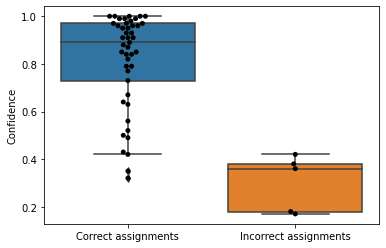

In [23]:
import seaborn as sns

ax = sns.boxplot(data=[correct_assignment_confidences, incorrect_assignment_confidences])
ax = sns.swarmplot(data=[correct_assignment_confidences, incorrect_assignment_confidences], color="black")
_ = ax.set_xticklabels(['Correct assignments', 'Incorrect assignments'])
_ = ax.set_ylabel('Confidence')

ax

What does this plot tell you about how well setting a confidence threshold is likely to work? If you never wanted to reject a correct assignment, how often would you accept an incorrect assignment? If you never wanted to accept an incorrect assignment, how often would you reject a correct assignment?

### Classifying with confidence

TODO: Integrate classifier code with confidence computations.

### Precision, recall, and F-measure

TODO: write this

```{admonition} Exercise
Jump back up to where we [defined `k` and `taxonomic_level`](ml:define-nb-parameters) and modify those values. How does the accuracy of the classifier change if you increase or decrease `k` while keeping the value of `taxonomic_level` fixed? How does the accuracy change if you increase or decrease the `taxonomic_level` while keeping `k` fixed? 
```

## Dimensionality reduction

TODO: transfer content from IAB